In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Load the dataset (replace with your actual file path)
#df = pd.read_csv('data/2024-06-01_2024-09-01/aggregated/percent_return.csv')
#df = pd.read_csv('data/2024-08-20_2024-08-28/aggregated/percent_return.csv')
#df = pd.read_csv('data/2023-09-01_2024-09-01/aggregated/percent_return.csv') # 1 year's worth of data
print(df.shape)
clustered_df = pd.read_csv('data/Cluster_data/Clusters.csv')

# Extract stock names
stock_names = clustered_df.columns[1:]  # Assuming the first column is the date

# Get companies in Cluster 1, dropping any NaN values
cluster_2_companies = clustered_df['Cluster 2'].dropna().tolist()

# Filter the dataset to include only Cluster 1 companies
df_cluster_2 = df[['date'] + [col for col in df.columns if col in cluster_2_companies]]
df_cluster_2.head(11)
# Print the filtered DataFrame
counter=0
for col in df_cluster_2.columns:
    print(col)
    counter+=1
    print(counter)
df_cluster_2.to_csv("data\cluster_2")
#print(df) #every 5th row is a friday
#print(df) #every 5th row is a friday

(63, 502)
date
1
ABBV
2
ACN
3
ADBE
4
ADI
5
ADP
6
AES
7
AFL
8
AIG
9
AIZ
10
AKAM
11
ANSS
12
APD
13
ATO
14
AXON
15
BEN
16
BR
17
BSX
18
CAG
19
CAH
20
CDNS
21
CDW
22
CEG
23
CF
24
CHTR
25
CINF
26
CLX
27
CMCSA
28
CME
29
CMG
30
COO
31
COR
32
COST
33
CPAY
34
CPB
35
CTAS
36
CVS
37
DE
38
DG
39
DGX
40
DIS
41
DLTR
42
DOC
43
DTE
44
DUK
45
EA
46
EBAY
47
ECL
48
ED
49
EG
50
EIX
51
ELV
52
EMR
53
EQIX
54
ES
55
EVRG
56
EW
57
EXC
58
EXPD
59
FDS
60
FDX
61
FIS
62
FTNT
63
GDDY
64
GILD
65
GIS
66
GL
67
GPC
68
HCA
69
HII
70
HON
71
HRL
72
HSY
73
IDXX
74
IFF
75
INCY
76
IQV
77
ISRG
78
IT
79
ITW
80
J
81
JKHY
82
JPM
83
KEYS
84
KO
85
KR
86
LDOS
87
LH
88
LHX
89
LIN
90
LNT
91
LVS
92
LYB
93
LYV
94
MA
95
MCD
96
MCK
97
MCO
98
MDLZ
99
META
100
MKTX
101
MLM
102
MMM
103
MNST
104
MOH
105
MRK
106
NDAQ
107
NDSN
108
NEE
109
NI
110
NKE
111
NOW
112
NSC
113
NXPI
114
PANW
115
PARA
116
PCG
117
PEG
118
PGR
119
PM
120
PNC
121
PNW
122
PPL
123
RF
124
ROP
125
RTX
126
SBUX
127
SHW
128
SJM
129
SNPS
130
SO
131
STT
132
STX
133
STZ
134
SYY
135


In [15]:
# Prepare the data for Monday to Thursday (features) and Friday (target)
X = []
y = []

# Iterate over the dataset in chunks of 5 rows (representing one week)
for i in range(0, len(df_cluster_2), 5):
    if i + 4 >= len(df_cluster_2):  # Prevent going out of bounds
        break
    # Monday to Thursday data (features)
    X.extend(df_cluster_2.iloc[i:i+4, 1:].T.values.tolist()) # rows are companies
    #X += df.iloc[i:i+4, 1:].T.values
    # Friday data (target)
    y.extend(df_cluster_2.iloc[i+4, 1:].T.values.tolist())  # Friday returns as target

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np

# Define the parameter distributions
param_dist = {
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2],
    'gamma': [0, 2, 4, 6, 8, 10],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_delta_step': [0, 2, 4, 6, 8, 10],
    'n_estimators': [100, 150, 200, 250, 300],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'alpha': [0, 1, 2, 5, 10],  # L1 regularization
    'lambda': [1, 2, 4, 6, 8, 10],  # Adjusted L2 regularization
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings to sample
    scoring='r2',  # Optimize for R^2 score
    cv=TimeSeriesSplit(n_splits=5),  # 5-fold cross-validation, with time series(stock data)
    random_state=42,  # For reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the random search
random_search.fit(X_train, y_train)

# Output best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)

# Retrieve the best model
best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

# Evaluate the model on the test set
predictions = best_model.predict(X_test)

Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'max_delta_step': 10, 'learning_rate': 0.03, 'lambda': 8, 'gamma': 6, 'alpha': 10}
Best R^2 Score: 0.04588685815123372


In [17]:
from sklearn.dummy import DummyRegressor

# Baseline model that predicts the mean y for all feature values
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)

In [18]:
# Calculate R^2 scores
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='r2')
print("Cross-Validation Scores (Training Data):", cv_scores)
print("Mean CV R^2 Score:", np.mean(cv_scores))

# Evaluate on test set
test_r2 = r2_score(y_test, best_model.predict(X_test))
print("Test R^2 Score:", test_r2)

baseline_r2 = r2_score(y_test, baseline_predictions) # should be 0, since it predicts the mean
print(f"Baseline R^2 Score: {baseline_r2}")


Cross-Validation Scores (Training Data): [0.04439041 0.05549444 0.03458788 0.03354243 0.06141913]
Mean CV R^2 Score: 0.04588685815123372
Test R^2 Score: 0.036186724080528476
Baseline R^2 Score: -0.005608365915204194


In [19]:
### Model evaluation
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse}")

# Calculate RMSE for baseline
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Baseline RMSE:", baseline_rmse)
print("Model Improvement:", baseline_rmse - rmse)

Model RMSE: 1.300426875202493
Baseline RMSE: 1.328323704921365
Model Improvement: 0.027896829718871974


In [20]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse:.2f}")

# Calculate Baseline RMSE
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Model Improvement: {baseline_rmse - rmse:.2f}")

# Daily change standard deviation
daily_changes = np.diff(y_test).std()
print(f"Daily Change Std Dev: {daily_changes:.2f}")

Model RMSE: 1.30
Baseline RMSE: 1.33
Model Improvement: 0.03
Daily Change Std Dev: 1.81


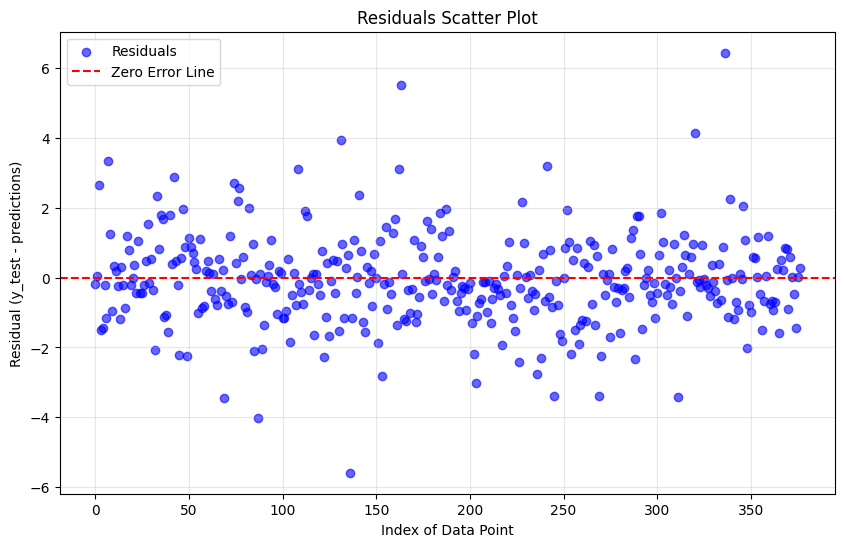

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Residuals (errors for each prediction)
residuals = y_test - predictions

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.6, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('Residual (y_test - predictions)')
plt.title('Residuals Scatter Plot')
plt.legend()
plt.grid(alpha=0.3)

plt.show()


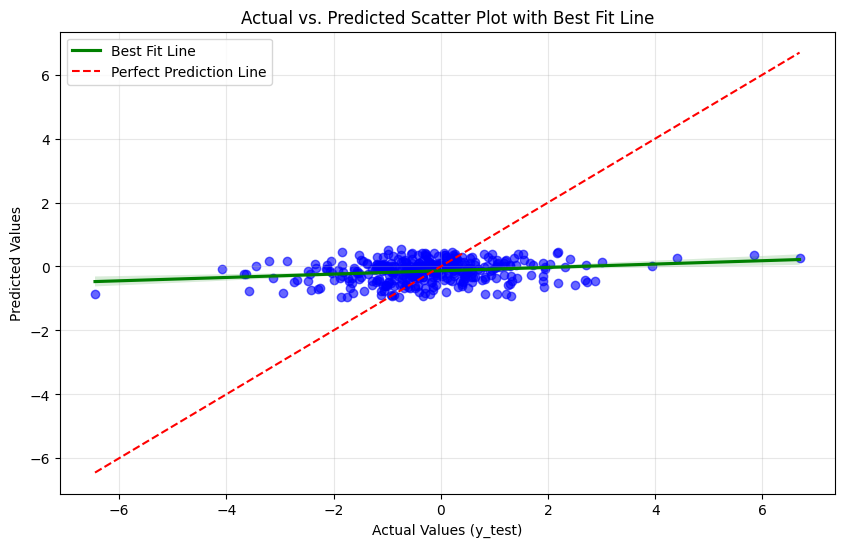

In [22]:
import seaborn as sns

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha': 0.6, 'label': 'Predicted vs. Actual'}, color='blue', line_kws={'color': 'green', 'label': 'Best Fit Line'})

# Add perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction Line')

# Labels and title
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Scatter Plot with Best Fit Line')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

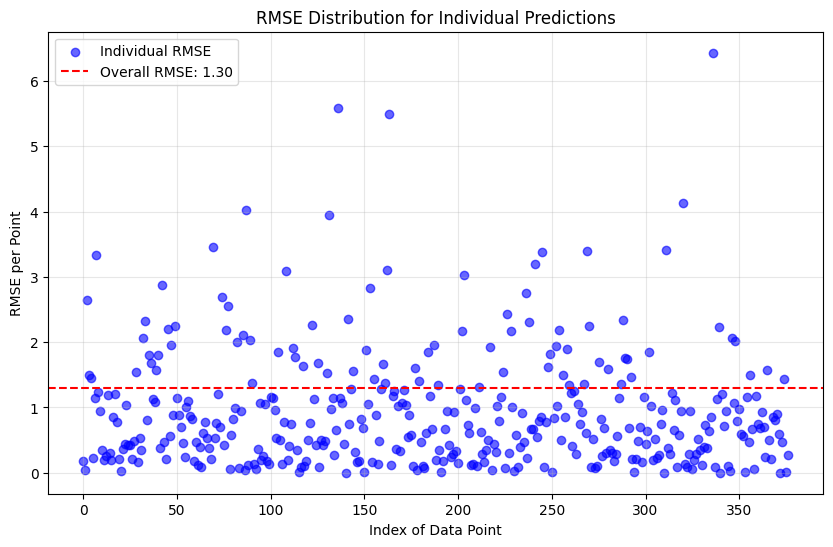

In [23]:
# Calculate individual RMSE values (absolute errors)
individual_rmse = np.sqrt((y_test - predictions) ** 2)

# Scatter plot of individual RMSE values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(individual_rmse)), individual_rmse, alpha=0.6, color='blue', label='Individual RMSE')
plt.axhline(y=rmse, color='red', linestyle='--', label=f'Overall RMSE: {rmse:.2f}')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('RMSE per Point')
plt.title('RMSE Distribution for Individual Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.show()
